# Data Wrangling with Spark 

Este é o código usado no screencast anterior. Execute cada célula de código para entender o que o código faz e como funciona.

Essas três primeiras células importam bibliotecas, instanciam uma SparkSession e, em seguida, lêem o conjunto de dados

In [1]:
# Package ---------------------------
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
spark = SparkSession \
    .builder \
    .appName("wranglig_data") \
    .getOrCreate()

In [3]:
path = "data/sparkify_log_small.json"
user_log = spark.read.json(path)

## Data exploration
As próximas células exploram o conjunto de dados.

In [4]:
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [7]:
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [8]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [9]:
user_log.count()

10000

In [10]:
user_log.select('page').dropDuplicates().sort('page').show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [11]:
user_log.select(['userId','firstname','page','song']).where(user_log.userId == '1046').collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

## Calculating Statistics by Hour

In [12]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [13]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [14]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='14')

In [15]:
songs_in_hour = user_log.filter(user_log.page == 'NextSong').groupBy(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [16]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  375|
|   1|  249|
|   2|  216|
|   3|  228|
|   4|  251|
|   5|  339|
|   6|  462|
|   7|  479|
|   8|  484|
|   9|  430|
|  10|  362|
|  11|  295|
|  12|  257|
|  13|  248|
|  14|  369|
|  15|  375|
|  16|  456|
|  17|  454|
|  18|  382|
|  19|  302|
+----+-----+
only showing top 20 rows



In [17]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

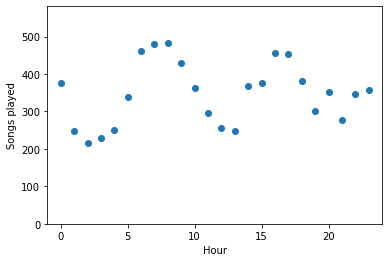

In [18]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd['count']))
plt.xlabel('Hour')
plt.ylabel("Songs played");

## Drop Rows with Missing Values
Como você verá, não há valores ausentes nas colunas de ID do usuário ou sessão. Mas existem valores de ID de usuário que são cadeias de caracteres vazias.

In [19]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [20]:
user_log_valid.count()

10000

In [21]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [22]:
user_log_valid = user_log_valid.filter(user_log_valid['userId'] != "")

In [23]:
user_log_valid.count()

9664

In [24]:
user_log_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
|  1048|
+------+
only showing top 20 rows



## Users Downgrade Their Accounts
Descubra quando os usuários fazem o downgrade de suas contas e, a seguir, sinalize essas entradas de registro. Em seguida, use uma função de janela e soma cumulativa para distinguir os dados de cada usuário como eventos pré ou pós-downgrade.

In [25]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   3|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [26]:
user_log.select(['userId','firstname','page','level','song']).where(user_log.userId == '1138').collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [27]:
flag_downgrade_event = udf(lambda x: i if x == "Submit Downgrade" else 0, IntegerType())

In [28]:
user_log_valid = user_log_valid.withColumn("downgraded",flag_downgrade_event("page"))

In [29]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='14', downgraded=0)

In [30]:
from pyspark.sql import Window

In [31]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [32]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [49]:
user_log_valid.select(["userId", "firstname","ts", "page","level", 'gender']).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', gender='F'),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', gender='F'),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', gender='F'),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', gender='F'),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', gender='F'),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', gender='F'),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', gender='F'),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', gender='F'),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', gender='F'),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', gender=

# Answer key to the Data Wrangling with Data Frames Coding Quiz

In [76]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

## Question 1
 Which page did user id "" (empty string) NOT visit?

In [67]:
user_log_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- phase: long (nullable = true)



In [77]:
# filter for users with blank user id
blank_pages = user_log_valid.filter(user_log_valid.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

In [78]:
# get a list of possible pages that could be visited
all_pages = user_log_valid.select('page').dropDuplicates()

In [79]:
# find values in all_pages that are note in blank_pages
#there are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row)

Row(page='Settings')
Row(page='Logout')
Row(page='Save Settings')
Row(page='Submit Upgrade')
Row(page='Home')
Row(page='About')
Row(page='Error')
Row(page='NextSong')
Row(page='Help')
Row(page='Upgrade')
Row(page='Downgrade')
Row(page='Submit Downgrade')


# Question 2
How many female users do we have in the data set?

In [55]:
user_log_valid.select("gender").dropDuplicates().sort("gender").show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [84]:
user_log_valid.select('userId','gender').dropDuplicates().where(user_log_valid.gender == 'F').count()

462

In [80]:
user_log_valid.filter(user_log_valid.gender == "F") \
    .select("userId","gender") \
    .dropDuplicates() \
    .count()

462

## Question 3
How many songs were played from the most played artist?

In [88]:
user_log_valid.filter(user_log_valid.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':"count"}) \
    .withColumnRenamed("count(Artist)", 'Artist Count') \
    .sort(desc("Artist Count")) \
    .show(1)

+--------+------------+
|  Artist|Artist Count|
+--------+------------+
|Coldplay|          83|
+--------+------------+
only showing top 1 row



## Question 4 (Challenge)
How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

In [90]:
# TODO: filter out 0 sum and max sum to get more exact answer

function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = user_log_valid.filter((user_log_valid.page == 'NextSong') | (user_log_valid.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 6.898347107438017|
+------------------+

